# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [5]:
%%time
path = os.path.join('download', 'covariates.tsv')
X = pd.read_table(path, index_col=0)

CPU times: user 99.5 ms, sys: 14.5 ms, total: 114 ms
Wall time: 140 ms


In [6]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 58s, sys: 6.81 s, total: 2min 5s
Wall time: 2min 6s


In [9]:
# Remove number of mutations column.
X = X.drop('n_mutations_log1p',axis=1)
X.head(6)

ValueError: labels ['n_mutations_log1p'] not contained in axis

In [10]:
# Which columns have NaN values? 
X.columns[pd.isnull(X).any()].tolist()

['age_diagnosed', 'days_survived', 'days_recurrence_free']

In [11]:
y = Y[GENE]

In [12]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [13]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.645907
1    0.354093
Name: 7157, dtype: float64

## Set aside 10% of the data for testing

In [14]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 69 features, 6,575 training samples, 731 testing samples'

## Median absolute deviation feature selection

In [15]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [16]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'select__k': ['all'],
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('select', SelectKBest(fs_mad)),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

In [17]:
%%time
cv_pipeline.fit(X=X_train, y=y_train)

CPU times: user 7.66 s, sys: 609 ms, total: 8.27 s
Wall time: 4.62 s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('select', SelectKBest(k=10, score_func=<function fs_mad at 0x162341e18>)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SGDClassifier(alpha=0.0001, average=Fa...      penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__penalty': ['elasticnet'], 'classify__alpha': [0.001, 0.01, 0.1, 1], 'select__k': ['all'], 'classify__l1_ratio': [0, 0.2, 0.8, 1], 'classify__loss': ['log']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [18]:
# Best Params
print('{:.3%}'.format(cv_pipeline.best_score_))

# Best Params
cv_pipeline.best_params_

82.240%


{'classify__alpha': 0.1,
 'classify__l1_ratio': 0,
 'classify__loss': 'log',
 'classify__penalty': 'elasticnet',
 'select__k': 'all'}

## Visualize hyperparameters performance

In [19]:
cv_result_df = pd.concat([
    pd.DataFrame(cv_pipeline.cv_results_),
    pd.DataFrame.from_records(cv_pipeline.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,param_select__k,params,...,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty,select__k
0,0.103818,0.017441,0.770696,0.783043,0.001,0,log,elasticnet,all,"{'classify__penalty': 'elasticnet', 'classify_...",...,0.789679,0.070088,0.014030,0.016218,0.006671,0.001,0.0,log,elasticnet,all
1,0.065237,0.007603,0.789023,0.798308,0.001,0.2,log,elasticnet,all,"{'classify__penalty': 'elasticnet', 'classify_...",...,0.788407,0.005843,0.000312,0.007480,0.007104,0.001,0.2,log,elasticnet,all


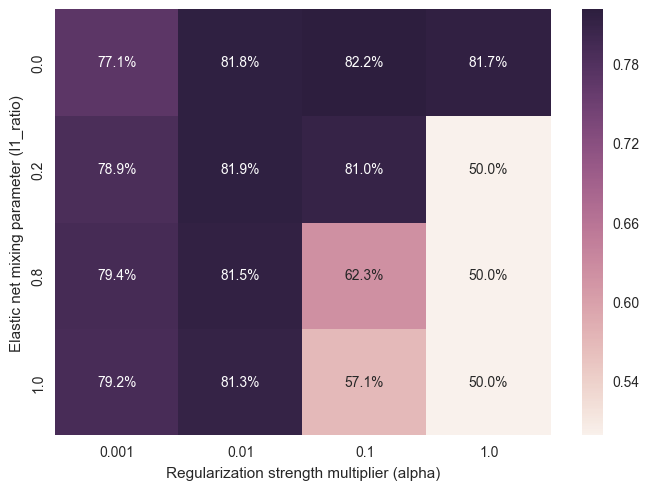

In [20]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [21]:
y_pred_train = cv_pipeline.decision_function(X_train)
y_pred_test = cv_pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

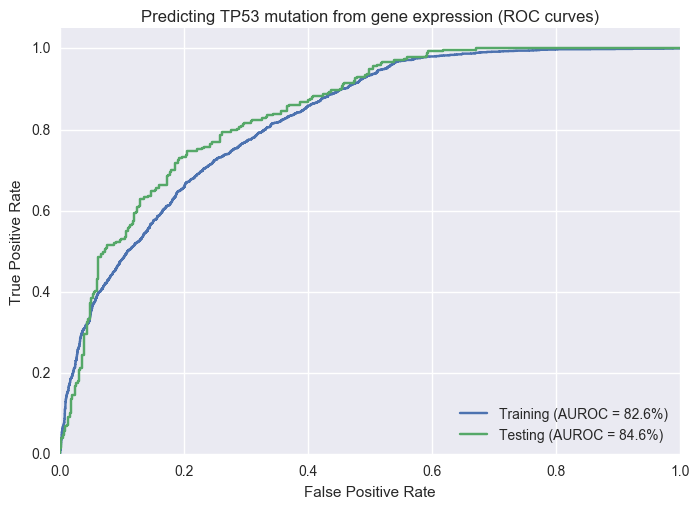

In [22]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [23]:
final_pipeline = cv_pipeline.best_estimator_
final_classifier = final_pipeline.named_steps['classify']

In [24]:
select_indices = final_pipeline.named_steps['select'].transform(
    np.arange(len(X.columns)).reshape(1, -1)
).tolist()

coef_df = pd.DataFrame.from_items([
    ('feature', X.columns[select_indices]),
    ('weight', final_classifier.coef_[0]),
])

coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [25]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'0.0% zero coefficients; 36 negative and 33 positive coefficients'

In [26]:
coef_df.head(10)

,feature,weight,abs
61,organ_Thyroid Gland,-0.216101,0.216101
30,acronym_THCA,-0.216101,0.216101
12,acronym_HNSC,0.172645,0.172645
45,organ_Head and Neck region,0.172645,0.172645
46,organ_Kidney,-0.155578,0.155578
21,acronym_OV,0.151022,0.151022
51,organ_Ovary,0.151022,0.151022
43,organ_Esophagus,0.150036,0.150036
10,acronym_ESCA,0.150036,0.150036
19,acronym_LUSC,0.146989,0.146989


## Investigate the predictions

In [27]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', cv_pipeline.decision_function(X)),
    ('probability', cv_pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [28]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-N6-A4VD-01,TCGA-N6-A4VD-01,0,0,1.941517,0.874519,87.5%
TCGA-13-1506-01,TCGA-13-1506-01,0,0,1.925071,0.872703,87.3%
TCGA-N7-A4Y0-01,TCGA-N7-A4Y0-01,0,0,1.918914,0.872017,87.2%
TCGA-NG-A4VW-01,TCGA-NG-A4VW-01,0,0,1.914252,0.871496,87.1%
TCGA-ND-A4WF-01,TCGA-ND-A4WF-01,0,0,1.895251,0.869353,86.9%
TCGA-13-0897-01,TCGA-13-0897-01,1,0,1.888913,0.868631,86.9%
TCGA-ND-A4WA-01,TCGA-ND-A4WA-01,0,0,1.883913,0.868060,86.8%
TCGA-L5-A88W-01,TCGA-L5-A88W-01,0,0,1.867672,0.866189,86.6%
TCGA-V5-AASV-01,TCGA-V5-AASV-01,0,0,1.848516,0.863953,86.4%


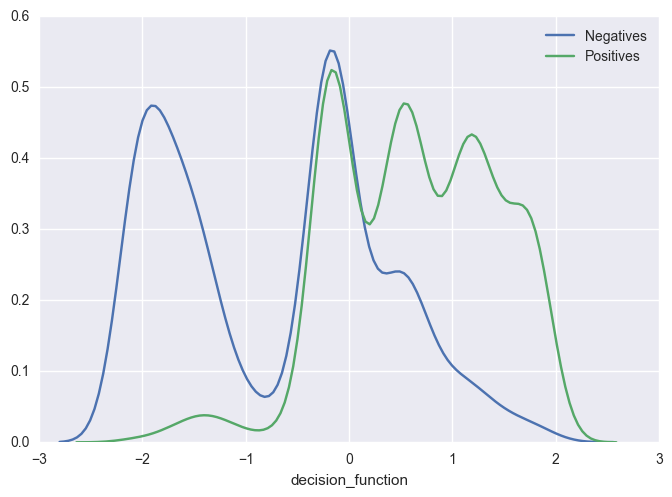

In [29]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

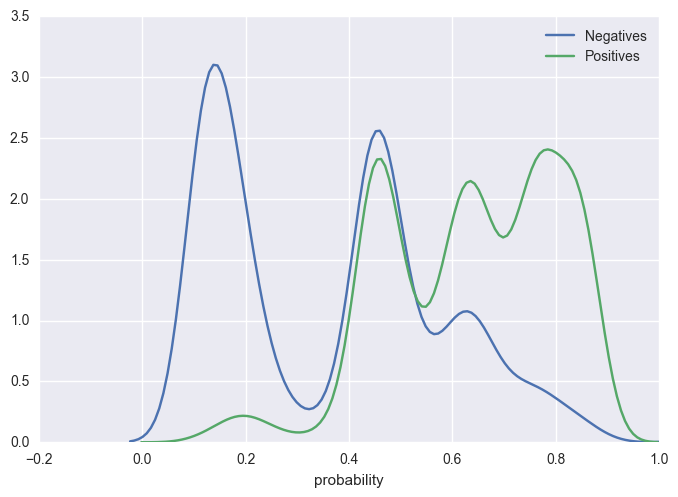

In [30]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')